In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM
from tqdm.notebook import tqdm

import camb

In [2]:
class LogUniformPrior:

  def __init__(self, limits):

    self.limits = limits
    self.parameter_names = list(limits.keys())
    self.n_params = len(limits)

  def __call__(self, kwargs):
    for key, value in kwargs.items():
      if kwargs[key] < self.limits[key][0] or kwargs[key] > self.limits[key][1]:
        return -np.inf
    return 0
  def generate(self, n_samples):

    samples = np.random.uniform(0,1, (self.n_params, n_samples))

    for i, (key, value) in enumerate(self.limits.items()):
      samples[i] = samples[i] * (value[1] - value[0]) + value[0]
    return samples

In [3]:
def model(params, z_star):

  camb_params = camb.CAMBparams()
  camb_params.set_cosmology(**params)
  camb_result = camb.get_background(camb_params)
  rs_star = camb_result.sound_horizon(z_star)
  Dm_star = camb_result.angular_diameter_distance(z_star) * (1+z_star)

  return rs_star/Dm_star, camb_params.ombh2, camb_params.omch2+camb_params.ombh2

In [4]:
class LogLikelihood:

  def __init__(self):

    self.data = [0.01041, 0.02223, 0.14208]

    self.cov = 1.e-9 * np.array( [ [ 0.006621, 0.12444, -1.1929], [0.12444, 21.344, -94.001], [-1.1929, -94.001, 1488.4]])

    self.inv_cov = np.linalg.inv(self.cov)

    self.z_star = 1089

  def __call__(self, params):

      mu_pred = np.array(model(params, self.z_star))

      diff = self.data-mu_pred

      chi2 = diff @ self.inv_cov @ diff

      return -0.5 * chi2

In [5]:
# METODO PER FARE MONTE CARLO, a differenza di MCMC decido come estrarre i punti, in questo caso l'estrazione è gaussiana

class MetropolisHastings:

  def __init__(self, log_prior, log_likelihood):

    self.log_prior = log_prior
    self.log_likelihood = log_likelihood
    self.parameter_names = self.log_prior.parameter_names
    self.n_params = self.log_prior.n_params

    self.chain = None
    self.acceptance = None
    self.log_post_chain = None

  def x_to_dict(self, x):

    return {self.parameter_names[i]:x[i] for i in range(len(x))}

  def __call__(self, x0, n_steps, proposal):

    chain = []
    acceptance = [True]

    x0_dict = self.x_to_dict(x0)
    chain.append(x0)
    log_post_chain = [self.log_prior(x0_dict) + self.log_likelihood(x0_dict)]

    for i in tqdm(range(n_steps)):
      x_try = proposal(chain[-1])
      x_try_dict = self.x_to_dict(x_try)

      log_post_chain_try = self.log_likelihood(x_try_dict) + self.log_prior(x_try_dict)
      log_ratio = log_post_chain_try - log_post_chain[-1]
      log_u = np.log(np.random.uniform())

      if log_u < log_ratio:
        chain.append(x_try)
        log_post_chain.append(log_post_chain_try)
        acceptance.append(True)
      else:
        chain.append(chain[-1])
        log_post_chain.append(log_post_chain[-1])
        acceptance.append(False)


      self.chain = np.array(chain)
      self.acceptance = np.array(acceptance)
      self.log_post_chain = np.array(log_post_chain)


In [6]:
limits = {}
limits['H0'] = [60, 75]
#limits['ombh2'] = 0.02223
limits['omch2'] = [0.11, 0.13]

In [7]:
log_prior = LogUniformPrior(limits)
log_likelihood = LogLikelihood()

In [8]:
def proposal(x, loc=[0.1, 0.0005]):
  return np.random.normal(x, loc)

In [9]:
mcmc = MetropolisHastings(log_prior, log_likelihood)

In [10]:
mcmc([65, 0.12], 10000, proposal)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
sum(mcmc.acceptance), len(mcmc.acceptance)

(np.int64(3860), 10001)

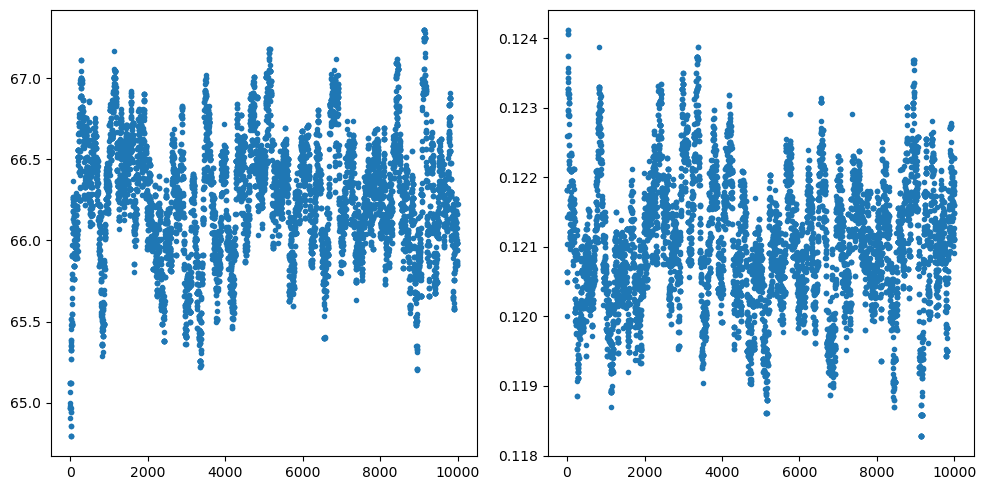

In [12]:
#non ho tolto i punti della catena che ti fanno capire che deve muoversi nella catena.
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mcmc.chain[:,0], ".")
ax[1].plot(mcmc.chain[:,1], ".")
figure.tight_layout()

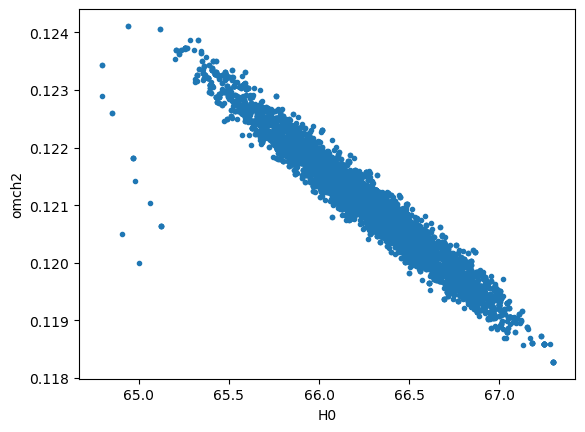

In [13]:
plt.plot(mcmc.chain[:,0], mcmc.chain[:,1], ".")
plt.xlabel("H0")
plt.ylabel("omch2")
plt.show()